# GPT-Q

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from pennylane import numpy as np

torch.set_printoptions(precision=3)

In [3]:
from models import QConv1d

ks = 5  # kind of arbitrary, limited by the number of available qubits
p = (ks - 1) // 2

qconv = QConv1d(kernel_size=ks, out_channels=3, n_qlayers=1, stride=1, padding=p)
qconv.draw()

/Users/disipio/development/gpt-q/venv/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


 0: ──RX(0)──RX(2.89)───╭C──────────────╭X──┤ ⟨Z⟩ 
 1: ──RX(0)──RX(4.37)───╰X──╭C──────────│───┤ ⟨Z⟩ 
 2: ──RX(0)──RX(0.551)──────╰X──╭C──────│───┤ ⟨Z⟩ 
 3: ──RX(0)──RX(1.94)───────────╰X──╭C──│───┤     
 4: ──RX(0)──RX(5.05)───────────────╰X──╰C──┤     



In [56]:
batch_size = 1
seq_len = 4
embed_dim = 8
x = torch.rand((batch_size, seq_len, embed_dim))
print(x.shape)
print(x)

torch.Size([1, 4, 8])
tensor([[[0.310, 0.500, 0.655, 0.777, 0.563, 0.625, 0.045, 0.495],
         [0.071, 0.888, 0.020, 0.053, 0.069, 0.692, 0.083, 0.517],
         [0.164, 0.454, 0.252, 0.570, 0.795, 0.342, 0.162, 0.544],
         [0.562, 0.461, 0.636, 0.300, 0.554, 0.463, 0.585, 0.177]]])


In [57]:
z = qconv(x)
print(z.shape)

torch.Size([1, 4, 8, 3])


In [58]:
z[:, :, :, 0].shape

torch.Size([1, 4, 8])

In [59]:
zc = z.view((1, 4, embed_dim*3))
print(zc.shape)

torch.Size([1, 4, 24])


1 + (c*w + 2*p - k) / s = w
=> (c*w - k) / s = w - 1
=> s = (c*w - k) / (w - 1)
this has to be an integer.

n = (c*w - k) / (w - 1) => n * (w - 1) = c*w - k => k = c*w - n * (w - 1)
k = (3 - n) * w + n, 0 < k < 3*w

In [60]:
def find_k(w, c):
    for n in range(10):
        # n = (b*w - k) / (d - 1) => n * (d - 1) = b*w - k => k = b*w - n*w + n
        k = c*w - n * (w - 1)
        if k < 0:
            break
        print(k)

find_k(embed_dim, 4)

32
25
18
11
4


In [61]:
ks_inv = 3
stride_inv = (3 * embed_dim - ks_inv) // (embed_dim - 1)
print(f"kernel size (=no. of qubits): {ks_inv}")
print(f"stride: {stride_inv}")
qconv_inv = QConv1d(kernel_size=ks_inv, out_channels=1, n_qlayers=1, stride=stride_inv, padding=0)
qconv_inv.draw()

kernel size (=no. of qubits): 3
stride: 3
 0: ──RX(0)──RX(0.386)──╭C──────╭X──┤ ⟨Z⟩ 
 1: ──RX(0)──RX(5.78)───╰X──╭C──│───┤     
 2: ──RX(0)──RX(0.339)──────╰X──╰C──┤     



In [62]:
y = qconv_inv(zc).view((batch_size, seq_len, -1))
print(y.shape)

torch.Size([1, 4, 8])


In [63]:
x = torch.arange(24).view(1, 2, 4, 3)
print(x)

tensor([[[[ 0,  1,  2],
          [ 3,  4,  5],
          [ 6,  7,  8],
          [ 9, 10, 11]],

         [[12, 13, 14],
          [15, 16, 17],
          [18, 19, 20],
          [21, 22, 23]]]])


In [64]:
x = x.transpose(-1,-2).view(1,2,3,-1)
print(x)
x = x.reshape((1,2,12))
print(x)


tensor([[[[ 0,  3,  6,  9],
          [ 1,  4,  7, 10],
          [ 2,  5,  8, 11]],

         [[12, 15, 18, 21],
          [13, 16, 19, 22],
          [14, 17, 20, 23]]]])
tensor([[[ 0,  3,  6,  9,  1,  4,  7, 10,  2,  5,  8, 11],
         [12, 15, 18, 21, 13, 16, 19, 22, 14, 17, 20, 23]]])


In [65]:
print(zc)
zc.transpose(-1, -2)

tensor([[[ 2.837e-02,  9.960e-01, -3.804e-01,  6.729e-02,  9.375e-01,
          -5.154e-01,  4.412e-03,  8.373e-01, -5.624e-01,  2.919e-02,
           7.044e-01, -5.332e-01, -1.181e-01,  5.778e-01, -3.474e-01,
          -2.614e-02,  6.345e-01, -4.119e-01, -3.615e-02,  7.000e-01,
          -8.884e-02, -2.691e-01,  8.537e-01, -4.654e-01],
         [-2.798e-02,  9.960e-01, -1.521e-01, -3.674e-01,  9.908e-01,
          -8.172e-01, -2.644e-02,  6.025e-01, -6.152e-02,  1.809e-02,
           6.916e-01, -9.328e-02, -3.616e-02,  9.941e-01, -1.496e-01,
          -1.908e-02,  9.940e-01, -6.946e-01, -4.321e-02,  7.465e-01,
          -1.226e-01, -2.772e-01,  8.142e-01, -4.589e-01],
         [-5.107e-02,  9.960e-01, -2.425e-01,  9.954e-03,  9.767e-01,
          -4.985e-01,  4.539e-02,  8.794e-01, -2.882e-01, -5.328e-02,
           8.934e-01, -5.421e-01, -1.886e-01,  8.099e-01, -6.228e-01,
          -7.285e-04,  5.951e-01, -2.446e-01, -7.682e-02,  7.031e-01,
          -1.699e-01, -2.843e-01,  9.476e-

tensor([[[ 2.837e-02, -2.798e-02, -5.107e-02,  3.846e-02],
         [ 9.960e-01,  9.960e-01,  9.960e-01,  9.960e-01],
         [-3.804e-01, -1.521e-01, -2.425e-01, -5.977e-01],
         [ 6.729e-02, -3.674e-01,  9.954e-03, -6.114e-02],
         [ 9.375e-01,  9.908e-01,  9.767e-01,  8.237e-01],
         [-5.154e-01, -8.172e-01, -4.985e-01, -4.256e-01],
         [ 4.412e-03, -2.644e-02,  4.539e-02,  3.345e-03],
         [ 8.373e-01,  6.025e-01,  8.794e-01,  7.798e-01],
         [-5.624e-01, -6.152e-02, -2.882e-01, -5.130e-01],
         [ 2.919e-02,  1.809e-02, -5.328e-02, -1.575e-02],
         [ 7.044e-01,  6.916e-01,  8.934e-01,  7.269e-01],
         [-5.332e-01, -9.328e-02, -5.421e-01, -2.707e-01],
         [-1.181e-01, -3.616e-02, -1.886e-01,  1.525e-02],
         [ 5.778e-01,  9.941e-01,  8.099e-01,  8.030e-01],
         [-3.474e-01, -1.496e-01, -6.228e-01, -4.767e-01],
         [-2.614e-02, -1.908e-02, -7.285e-04, -9.751e-02],
         [ 6.345e-01,  9.940e-01,  5.951e-01,  8.114e-01

### vectorize input to CNN

In [4]:
batch_size = 1
seq_len = 4
embed_dim = 8
x = torch.rand((batch_size, seq_len, embed_dim))
print(x.shape)
print(x)

torch.Size([1, 4, 8])
tensor([[[0.748, 0.760, 0.392, 0.578, 0.009, 0.153, 0.396, 0.015],
         [0.277, 0.517, 0.442, 0.646, 0.354, 0.107, 0.662, 0.863],
         [0.241, 0.592, 0.956, 0.684, 0.185, 0.334, 0.096, 0.115],
         [0.807, 0.812, 0.313, 0.964, 0.481, 0.842, 0.101, 0.879]]])


In [54]:
stride = 1
kernel_size = 3
padding = 0

In [55]:
from torch.nn import functional as F

out_dim = int((embed_dim + 2 * padding - kernel_size) / stride) + 1
z = F.pad(x, (padding, padding), "constant", 0)
print(z.shape)
print(f"out_dim: {out_dim}\n")
for i in range(batch_size):
    for j in range(seq_len):
        for k in range(0, out_dim):
            k_start = k*stride
            k_end = k_start + kernel_size
            z_slice  = z[i, j, k_start:k_end]
            print(z_slice)
        print('---')

torch.Size([1, 4, 8])
out_dim: 6

tensor([0.748, 0.760, 0.392])
tensor([0.760, 0.392, 0.578])
tensor([0.392, 0.578, 0.009])
tensor([0.578, 0.009, 0.153])
tensor([0.009, 0.153, 0.396])
tensor([0.153, 0.396, 0.015])
---
tensor([0.277, 0.517, 0.442])
tensor([0.517, 0.442, 0.646])
tensor([0.442, 0.646, 0.354])
tensor([0.646, 0.354, 0.107])
tensor([0.354, 0.107, 0.662])
tensor([0.107, 0.662, 0.863])
---
tensor([0.241, 0.592, 0.956])
tensor([0.592, 0.956, 0.684])
tensor([0.956, 0.684, 0.185])
tensor([0.684, 0.185, 0.334])
tensor([0.185, 0.334, 0.096])
tensor([0.334, 0.096, 0.115])
---
tensor([0.807, 0.812, 0.313])
tensor([0.812, 0.313, 0.964])
tensor([0.313, 0.964, 0.481])
tensor([0.964, 0.481, 0.842])
tensor([0.481, 0.842, 0.101])
tensor([0.842, 0.101, 0.879])
---


In [66]:
idx = np.arange(0, kernel_size)
x[:,:,idx]

tensor([[[0.748, 0.760, 0.392],
         [0.277, 0.517, 0.442],
         [0.241, 0.592, 0.956],
         [0.807, 0.812, 0.313]]])

In [80]:
idx = np.expand_dims(np.arange(kernel_size), 0) + np.expand_dims(np.arange(out_dim), 0).T
print(idx)

[[0 1 2]
 [1 2 3]
 [2 3 4]
 [3 4 5]
 [4 5 6]
 [5 6 7]]


In [81]:
x[:,:,idx]

tensor([[[[0.748, 0.760, 0.392],
          [0.760, 0.392, 0.578],
          [0.392, 0.578, 0.009],
          [0.578, 0.009, 0.153],
          [0.009, 0.153, 0.396],
          [0.153, 0.396, 0.015]],

         [[0.277, 0.517, 0.442],
          [0.517, 0.442, 0.646],
          [0.442, 0.646, 0.354],
          [0.646, 0.354, 0.107],
          [0.354, 0.107, 0.662],
          [0.107, 0.662, 0.863]],

         [[0.241, 0.592, 0.956],
          [0.592, 0.956, 0.684],
          [0.956, 0.684, 0.185],
          [0.684, 0.185, 0.334],
          [0.185, 0.334, 0.096],
          [0.334, 0.096, 0.115]],

         [[0.807, 0.812, 0.313],
          [0.812, 0.313, 0.964],
          [0.313, 0.964, 0.481],
          [0.964, 0.481, 0.842],
          [0.481, 0.842, 0.101],
          [0.842, 0.101, 0.879]]]])

In [88]:
from models import QConv1d

qconv = QConv1d(kernel_size, stride=stride, padding=padding)

In [89]:
out = qconv(x)
print(out.shape)
print(out)

torch.Size([1, 4, 6, 3])
tensor([[[[0.973, 0.808, 0.797],
          [0.919, 0.795, 0.746],
          [0.976, 0.968, 0.945],
          [0.830, 0.752, 0.750],
          [0.890, 0.896, 0.883],
          [0.958, 0.980, 0.958]],

         [[0.973, 0.987, 0.964],
          [0.902, 0.918, 0.838],
          [0.990, 0.953, 0.945],
          [0.964, 0.848, 0.842],
          [0.799, 0.861, 0.780],
          [0.802, 0.997, 0.802]],

         [[0.744, 0.995, 0.740],
          [0.839, 0.841, 0.753],
          [0.995, 0.680, 0.679],
          [0.911, 0.782, 0.778],
          [0.958, 0.965, 0.957],
          [0.872, 0.860, 0.855]],

         [[0.973, 0.766, 0.763],
          [0.710, 0.749, 0.554],
          [0.903, 0.919, 0.889],
          [0.810, 0.673, 0.549],
          [0.963, 0.913, 0.906],
          [0.698, 0.670, 0.532]]]], grad_fn=<StackBackward>)


## FeedForward

In [77]:
from models import FeedForward

embed_dim = 8
n_qubits = 5
n_qlayers = 1
boom_factor = 4
ff = FeedForward(embed_dim, boom_factor=boom_factor, n_qubits=n_qubits, n_qlayers=n_qlayers)

In [81]:
batch_size = 1
seq_len = 4
embed_dim = 8
x = torch.rand((batch_size, seq_len, embed_dim))

print("input:", x.shape)
xff = ff.forward(x)
print("output:", xff.shape)

input: torch.Size([1, 4, 8])
output: torch.Size([1, 4, 8])


## Attention

In [9]:
batch_size = 1
seq_len = 4
embed_dim = 8
x = torch.rand((batch_size, seq_len, embed_dim))
print(x.shape)
print(x)

torch.Size([1, 4, 8])
tensor([[[0.964, 0.776, 0.797, 0.132, 0.005, 0.225, 0.763, 0.818],
         [0.998, 0.020, 0.987, 0.329, 0.430, 0.608, 0.548, 0.698],
         [0.829, 0.442, 0.601, 0.259, 0.688, 0.809, 0.910, 0.808],
         [0.446, 0.084, 0.925, 0.620, 0.958, 0.173, 0.355, 0.116]]])


In [82]:
from models import MultiHeadAttention

n_heads = 2
n_qubits = 5
n_qlayers = 1
n_heads = 4

attn = MultiHeadAttention(embed_dim, n_heads, n_qubits, n_qlayers)

In [83]:
out = attn(x)
print("output of attention:", out.shape)

output of attention: torch.Size([1, 4, 8])


## Transformer block

In [84]:
from models import TransformerBlock

transformer = TransformerBlock(embed_dim, n_heads=n_heads, n_qubits=n_qubits, n_qlayers=n_qlayers)

In [85]:
x_tf = transformer.forward(x)
print("transformer block output:", x_tf.shape)

transformer block output: torch.Size([1, 4, 8])


## GPT-Q Full Model

In [5]:
from models import GPTQ

embed_dim = 8
batch_size = 1
max_seq_len = 16
src_vocab = 8
tgt_vocab = 4 
n_layers = 2
n_heads = 4

gptq = GPTQ(embed_dim=embed_dim,
            src_vocab=src_vocab,
            tgt_vocab=tgt_vocab,
            n_heads=n_heads,
            n_layers=n_layers,
            max_seq_len=max_seq_len)

In [149]:
token_ids = np.random.choice(src_vocab, (batch_size, max_seq_len))
token_ids = torch.tensor(token_ids)
print(token_ids)

tensor([[1, 1, 1, 1, 2, 7, 3, 2, 6, 1, 3, 5, 0, 4, 3, 3]])


In [150]:
out = gptq(token_ids)
print("GPT-Q output:", out.shape)

GPT-Q output: torch.Size([1, 16, 4])


In [151]:
gptq.attn_mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

## Masks

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline

from utils import make_padding_mask, make_subsequent_mask, make_lookahead_mask

In [119]:
batch_size = 2
max_seq_len = 4
token_ids = np.random.choice(src_vocab, (batch_size, max_seq_len))
token_ids = torch.tensor(token_ids)
print(token_ids)

tensor([[5, 4, 2, 7],
        [6, 7, 5, 2]])


In [120]:
make_padding_mask(token_ids)

tensor([[[True, True, True, True]],

        [[True, True, True, True]]])

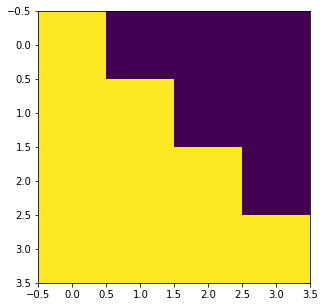

In [121]:
plt.figure(figsize=(5,5))
plt.imshow(make_subsequent_mask(max_seq_len)[0])

In [139]:
from utils import make_lookahead_mask, make_src_mask


token_ids = np.array([
    [1, 2, 3, 0, 0],
    [1, 2, 3, 4, 0]
], dtype=np.int32)
token_ids = torch.from_numpy(token_ids)

print(token_ids)
print(make_src_mask(token_ids.size(1)))

tensor([[1, 2, 3, 0, 0],
        [1, 2, 3, 4, 0]], dtype=torch.int32)
tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])


## Train Classifier

In [44]:
from torchtext.datasets import IMDB

In [45]:
train_iter, test_iter = IMDB(split=('train', 'test'))

In [46]:
len(train_iter), len(test_iter)

(25000, 25000)

In [47]:
train_data = []
for label, line in train_iter:
    train_data.append(line)
print(train_data[:3])

['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, e

In [48]:
from tokenizers import Tokenizer, models, normalizers, pre_tokenizers, decoders, trainers

vocab_size = 300
min_frequency = 2
special_tokens = [
        "<s>",
        "<pad>",
        "</s>",
        "<unk>",
        "<mask>",
    ]

tokenizer = Tokenizer(models.BPE())
tokenizer.normalizer = normalizers.NFKC()
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
tokenizer.decoders = decoders.ByteLevel()

trainer = trainers.BpeTrainer(
    vocab_size=vocab_size,
    initial_alphabet=pre_tokenizers.ByteLevel.alphabet(),
    min_frequency=min_frequency,
    special_tokens=special_tokens)

tokenizer.train_from_iterator(train_data, trainer=trainer)
tokenizer.save("gptq.json")

In [49]:
tokenizer.encode("Hello world").ids

[225, 44, 73, 287, 83, 268, 282, 80, 72]

## Fit IMDb Sentiment Analysis Model

In [15]:
from models import IMDbClassifier

embed_dim = 8
vocab_size = 2000
max_seq_len = 16
n_tlayers = 1
n_heads = 2
lr = 1e-3
n_qlayers = 1
q_device = 'qulacs.simulator'

classifier = IMDbClassifier(embed_dim=embed_dim,
                       vocab_size=vocab_size,
                       n_heads=n_heads,
                       n_tlayers=n_tlayers,
                       max_seq_len=max_seq_len,
                       q_device=q_device)

In [7]:
from dataset import IMDbDataModule

BATCH_SIZE = 32
#n_examples_max = 8 # for quick tests
n_examples_max = None

dm = IMDbDataModule(val_split=0.2,
                    batch_size=BATCH_SIZE,
                    max_seq_length=max_seq_len,
                    n_examples_max=n_examples_max)

In [ ]:
from pytorch_lightning import Trainer

AVAIL_GPUS = min(1, torch.cuda.device_count())

trainer = Trainer(
    max_epochs=4,
    gpus=AVAIL_GPUS,
    log_every_n_steps=2,
    progress_bar_refresh_rate=20)
trainer.fit(classifier, dm)

INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
/Users/disipio/development/gpt-q/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
INFO:pytorch_lightning.core.lightning:
  | Name    | Type             | Params
---------------------------------------------
0 | h       | ModuleList       | 51    
1 | wte     | Embedding        | 16.0 K
2 | wpe     | Embedding        | 128   
3 | dropout | Dropout          | 0     
4 | ln_f    | LayerNorm        | 16    
5 | out     | Linear           | 16    
6 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------


Validation sanity check: 0it [00:00, ?it/s]

/Users/disipio/development/gpt-q/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/disipio/development/gpt-q/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

In [104]:
torch.save(classifier.state_dict(), "imdb_classifier.pt")

In [105]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [106]:
%tensorboard --logdir ./lightning_logs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Fit Language Model

In [190]:
from models import LanguageModel

In [191]:
vocab_size = 2000
max_seq_len = 64
n_layers = 1
n_heads = 2
lr = 1e-3

model = LanguageModel(embed_dim=embed_dim,
                       vocab_size=vocab_size,
                       n_heads=n_heads,
                       n_layers=n_layers,
                       max_seq_len=max_seq_len)